In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.regularizers import l2

from keras.applications.imagenet_utils import _obtain_input_shape
import keras.backend as K
from keras.optimizers import Adam, SGD
from keras.callbacks import *
# from keras_contrib.applications import densenet

Using TensorFlow backend.


In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import re
import scipy
from PIL import Image
from skimage.transform import resize
from imageio import imread

### Define network

In [3]:
def fcn_vgg_8(input_shape, num_classes, weight_decay=5e-4):
    img_input = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    vgg_conv3_out = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(vgg_conv3_out)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    vgg_conv4_out = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(vgg_conv4_out)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    vgg_conv5_out = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    # convert dense layers to fully conv layers
    x = Conv2D(4096, (7, 7), activation='relu', padding='same', name='fc1', kernel_regularizer=l2(weight_decay))(vgg_conv5_out)
    x = Dropout(0.5)(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same', name='fc2', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    conv7_out = Conv2D(num_classes, (1, 1), activation='linear', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay), name='decoder_conv7')(x)   

    # decoder network
    vgg_conv4_conv1x1 = Conv2D(num_classes, (1, 1), activation='relu', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay),
                              name="layer4_conv1x1")(vgg_conv4_out)
    
    vgg_conv3_conv1x1 = Conv2D(num_classes, (1, 1), activation='relu', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay),
                              name="layer3_conv1x1")(vgg_conv3_out)
    
    upsample1 = Conv2DTranspose(num_classes, kernel_size=4, strides=(2,2), padding='same', kernel_regularizer=l2(weight_decay), name='upsample_1')(conv7_out)
    
    skip1 = Add()([upsample1, vgg_conv4_conv1x1])
    upsample2 = Conv2DTranspose(num_classes, kernel_size=4, strides=(2,2), padding='same', kernel_regularizer=l2(weight_decay), name='upsample_2')(skip1)
    
    skip2 = Add()([upsample2, vgg_conv3_conv1x1])
    upsample3 = Conv2DTranspose(num_classes, kernel_size=16, strides=(8,8), padding='same', kernel_regularizer=l2(weight_decay), name='upsample_3')(skip2)
    
    model = Model(img_input, upsample3)
    
    layers_list = model.layers
    index = {}
    
    for layer in layers_list:
        if layer.name:
            index[layer.name] = layer
            
    vgg16 = VGG16()
    for layer in vgg16.layers:
        weights = layer.get_weights()
        if layer.name=='fc1':
            weights[0] = np.reshape(weights[0], (7,7,512,4096))
        elif layer.name=='fc2':
            weights[0] = np.reshape(weights[0], (1,1,4096,4096))
        if layer.name in index:
            index[layer.name].set_weights(weights)
            index[layer.name].trainable = False
            
#     weights_path = os.path.expanduser(os.path.join('~', '.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'))
#     model.load_weights(weights_path, by_name=True)
    return model

#     fcn_weights_path = os.path.expanduser(os.path.join('~', '.keras/models/fcn_vgg16_weights_tf_dim_ordering_tf_kernels.h5'))

#     #transfer if weights have not been created
#     if os.path.isfile(weights_path) == False:
#         flattened_layers = model.layers
#         index = {}
#         for layer in flattened_layers:
#             if layer.name:
#                 index[layer.name]=layer
#         vgg16 = VGG16()
#         for layer in vgg16.layers:
#             weights = layer.get_weights()
#             if layer.name=='fc1':
#                 weights[0] = np.reshape(weights[0], (7,7,512,4096))
#             elif layer.name=='fc2':
#                 weights[0] = np.reshape(weights[0], (1,1,4096,4096))
# #             elif layer.name=='predictions':
# #                 layer.name='predictions_1000'
# #                 weights[0] = np.reshape(weights[0], (1,1,4096,1000))
#             if index.has_key(layer.name):
#                 index[layer.name].set_weights(weights)
#         model.save_weights(weights_path)

### Dumping some custom loss/metric functions here to see help me figure out which ones are correct to use

In [4]:
# https://github.com/aurora95/Keras-FCN/blob/master/utils/loss_function.py
def softmax_sparse_crossentropy_ignoring_last_label(y_true, y_pred):
    y_pred = K.reshape(y_pred, (-1, K.int_shape(y_pred)[-1]))
    log_softmax = tf.nn.log_softmax(y_pred)

    y_true = K.one_hot(tf.to_int32(K.flatten(y_true)), K.int_shape(y_pred)[-1]+1)
    unpacked = tf.unstack(y_true, axis=-1)
    y_true = tf.stack(unpacked[:-1], axis=-1)

    cross_entropy = -K.sum(y_true * log_softmax, axis=1)
    cross_entropy_mean = K.mean(cross_entropy)

    return cross_entropy_mean


# Softmax cross-entropy loss function for coco segmentation
# and models which expect but do not apply sigmoid on each entry
# tensorlow only
def binary_crossentropy_with_logits(ground_truth, predictions):
    return K.mean(K.binary_crossentropy(ground_truth,
                                        predictions,
                                        from_logits=True),
                  axis=-1)
def sparse_accuracy_ignoring_last_label(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    y_pred = K.reshape(y_pred, (-1, nb_classes))

    y_true = K.one_hot(tf.to_int32(K.flatten(y_true)),
                       nb_classes + 1)
    unpacked = tf.unstack(y_true, axis=-1)
    legal_labels = ~tf.cast(unpacked[-1], tf.bool)
    y_true = tf.stack(unpacked[:-1], axis=-1)

    return K.sum(tf.to_float(legal_labels & K.equal(K.argmax(y_true, axis=-1), K.argmax(y_pred, axis=-1)))) / K.sum(tf.to_float(legal_labels))


In [5]:
def fcn_binary_crossentropy(y_true, y_pred, from_logits=False):
    pred_shape = K.int_shape(y_pred)
    true_shape = K.int_shape(y_true)
    y_pred_reshaped = K.reshape(y_pred, (-1, 2))
    y_true_reshaped = K.reshape(y_true, (-1, 2))

    result = K.binary_crossentropy(y_pred_reshaped, y_true_reshaped,
                                   from_logits=from_logits)
    result = K.mean(result, axis=-1)

    if len(true_shape) >= 3:
        return K.reshape(result, true_shape[:-1])
    else:
        return result
    
def fcn_binary_crossentropy_with_regularisation(y_true, y_pred, from_logits=False):
    loss1 = fcn_binary_crossentropy(y_true, y_pred, from_logits=from_logits)
    loss2 = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES) + 5e-4 + K.sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
    
    return K.sum(loss1, loss2)

def pixelwise_crossentropy(target, output):
    output = tf.clip_by_value(output, 10e-8, 1. - 10e-8)
    return - tf.reduce_sum(target * tf.log(output))




In [6]:
# https://raw.githubusercontent.com/theduynguyen/Keras-FCN/master/loss_func.py

def fcn_xent(y_true, y_pred):
	y_true_reshaped = K.flatten(y_true)
	y_pred_reshaped = K.flatten(y_pred)

	return K.binary_crossentropy(y_pred_reshaped, y_true_reshaped)


def pixel_acc(y_true, y_pred):
	s = K.shape(y_true)

	# reshape such that w and h dim are multiplied together
	y_true_reshaped = K.reshape( y_true, tf.stack( [-1, s[1]*s[2], s[-1]] ) )
	y_pred_reshaped = K.reshape( y_pred, tf.stack( [-1, s[1]*s[2], s[-1]] ) )

	# correctly classified
	clf_pred = K.one_hot( K.argmax(y_pred_reshaped),s[-1])
	correct_pixels_per_class = K.cast( K.equal(clf_pred,y_true_reshaped), dtype='float32')

	return K.sum(correct_pixels_per_class) / K.cast(K.prod(s), dtype='float32')

def mean_acc(y_true, y_pred):
	s = K.shape(y_true)

	# reshape such that w and h dim are multiplied together
	y_true_reshaped = K.reshape( y_true, tf.stack( [-1, s[1]*s[2], s[-1]] ) )
	y_pred_reshaped = K.reshape( y_pred, tf.stack( [-1, s[1]*s[2], s[-1]] ) )

	# correctly classified
	clf_pred = K.one_hot( K.argmax(y_pred_reshaped), nb_classes = s[-1])
	equal_entries = K.cast(K.equal(clf_pred,y_true_reshaped), dtype='float32') * y_true_reshaped

	correct_pixels_per_class = K.sum(equal_entries, axis=1)
	n_pixels_per_class = K.sum(y_true_reshaped,axis=1)

	acc = correct_pixels_per_class / n_pixels_per_class
	acc_mask = tf.is_finite(acc)
	acc_masked = tf.boolean_mask(acc,acc_mask)

	return K.mean(acc_masked)

def mean_IoU(y_true, y_pred):
	s = K.shape(y_true)

	# reshape such that w and h dim are multiplied together
	y_true_reshaped = K.reshape( y_true, tf.stack( [-1, s[1]*s[2], s[-1]] ) )
	y_pred_reshaped = K.reshape( y_pred, tf.stack( [-1, s[1]*s[2], s[-1]] ) )

	# correctly classified
	clf_pred = K.one_hot( K.argmax(y_pred_reshaped), s[-1])
	equal_entries = K.cast(K.equal(clf_pred,y_true_reshaped), dtype='float32') * y_true_reshaped

	intersection = K.sum(equal_entries, axis=1)
	union_per_class = K.sum(y_true_reshaped,axis=1) + K.sum(y_pred_reshaped,axis=1)

	iou = intersection / (union_per_class - intersection)
	iou_mask = tf.is_finite(iou)
	iou_masked = tf.boolean_mask(iou,iou_mask)

	return K.mean( iou_masked )

In [7]:
lr_base = 0.01
fcn_optimizer = SGD(lr=lr_base, momentum=0.9)
# https://stackoverflow.com/questions/49715192/tensorflow-mean-iou-for-just-foreground-class-for-binary-semantic-segmentation/50266195#50266195

def keras_mean_iou(labels, predictions):
    """
    labels,prediction with shape of [batch,height,width,class_number=2]
    """
    mean_iou = K.variable(0.0)
    seen_classes = K.variable(0.0)
    
    print('keras mean iou')
    print(labels.shape)
    print(predictions.shape)

    for c in range(2):
        labels_c = K.cast(K.equal(labels, c), K.floatx())
        pred_c = K.cast(K.equal(predictions, c), K.floatx())
        
        print(labels_c, pred_c, 'here')

        labels_c_sum = K.sum(labels_c)
        pred_c_sum = K.sum(pred_c)

        intersect = K.sum(labels_c*pred_c)
        union = labels_c_sum + pred_c_sum - intersect
        iou = intersect / union
        condition = K.equal(union, 0)
        mean_iou = K.switch(condition,
                            mean_iou,
                            mean_iou+iou)
        seen_classes = K.switch(condition,
                                seen_classes,
                                seen_classes+1)

    mean_iou = K.switch(K.equal(seen_classes, 0),
                        mean_iou,
                        mean_iou/seen_classes)
    return mean_iou

### Getting the training/gt image paths for data generator

In [8]:
np.random.seed(10)
road_imgs_gt = glob.glob(os.path.join('./data', 'data_road/training', 'gt_image_2', '*_road_*.png'))
np.random.shuffle(road_imgs_gt)

In [9]:
road_imgs_gt[:10]

['./data/data_road/training/gt_image_2/uu_road_000083.png',
 './data/data_road/training/gt_image_2/uu_road_000062.png',
 './data/data_road/training/gt_image_2/umm_road_000039.png',
 './data/data_road/training/gt_image_2/um_road_000068.png',
 './data/data_road/training/gt_image_2/uu_road_000032.png',
 './data/data_road/training/gt_image_2/um_road_000045.png',
 './data/data_road/training/gt_image_2/um_road_000028.png',
 './data/data_road/training/gt_image_2/umm_road_000061.png',
 './data/data_road/training/gt_image_2/um_road_000090.png',
 './data/data_road/training/gt_image_2/umm_road_000054.png']

In [9]:
val_gt_arr = road_imgs_gt[:16]
val_img_arr = [x.replace('gt_image_2', 'image_2').replace('_road_', '_').replace('_lane_', '_') for x in val_gt_arr]
train_gt_arr = road_imgs_gt[16:]
train_img_arr = [x.replace('gt_image_2', 'image_2').replace('_road_', '_').replace('_lane_', '_') for x in train_gt_arr]

### Data generator

In [10]:
def train_generator(files_list, gt_list, batch_size, image_shape):

    background_color = np.array([1, 0, 0])
    images = []
    gt_images = []

    while True:
        for i in range(batch_size):
            index = np.random.choice(len(files_list), replace=False)
            image_file = files_list[index]
            gt_file = gt_list[index]
            gt_image = resize(imread(gt_file), image_shape)
            
            image = resize(imread(image_file), image_shape)

            gt_bg_mask = np.all(gt_image == background_color, axis=2)
            gt_image_bg = np.zeros(shape=(image_shape[0], image_shape[1]))
            gt_image_fg = np.ones(shape=(image_shape[0], image_shape[1]))


            gt_image_fg[gt_bg_mask] = 0
            gt_image_bg[gt_bg_mask] = 1
            
            gt_onehot = np.stack((gt_image_fg, gt_image_bg), axis=-1)
#             gt_onehot = np.moveaxis(gt_onehot, 0, -1)
            
            images.append(image)
            gt_images.append(gt_onehot)

#         yield images, gt_onehot
        yield np.array(images), np.array(gt_images)

In [35]:
def run(img_shape=(160, 576, 3), batch_size=4, epochs = 2,steps_per_epoch=10, lr=0.001):
    K.clear_session()
    
    tensorboardCB = TensorBoard(log_dir=os.path.join('tensorboard_graphs', 'fcn-keras'), write_graph=True)
    checkpointCB = ModelCheckpoint('checkpoints/fcn.-run2-epoch{epoch:02d}.h5', monitor=pixelwise_crossentropy, save_weights_only=False, mode='max', period=3)
    callbacks = [tensorboardCB, checkpointCB]
    
    IMAGE_SHAPE=img_shape
#     IMAGE_SHAPE=(160, 576, 3)
    batch_size = batch_size
    steps_per_epoch = steps_per_epoch #np.round(len(train_img_arr)/ batch_size)
    t_generator = train_generator(train_img_arr, train_gt_arr, batch_size, IMAGE_SHAPE)
    val_generator = train_generator(val_img_arr, val_gt_arr, batch_size, IMAGE_SHAPE)
    model_fcn = fcn_vgg_8(IMAGE_SHAPE, 2, weight_decay=5e-4)
    # freeze layers from vgg for now
    for idx, layer in enumerate(model_fcn.layers):
        if idx < 17:
            layer.trainable = False
    model_fcn.summary()
#     model_fcn.compile(loss=binary_crossentropy_with_logits,
#                   optimizer=Adam(),
#                   metrics=[pixelwise_crossentropy]
#                      )
    
    model_fcn.compile(loss=binary_crossentropy_with_logits,
                  optimizer=Adam(lr = lr),
#                   metrics=[pixelwise_crossentropy]
                     )
    
    history = model_fcn.fit_generator(t_generator, epochs = epochs, steps_per_epoch=steps_per_epoch,
                       validation_data = val_generator, validation_steps = 1, 
                            callbacks=callbacks)
    
    return model_fcn, history

In [36]:
model, history = run((64,64,3), batch_size=2, epochs=5, steps_per_epoch=len(train_img_arr)//2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 64, 64, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 32, 32, 64)   0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


136/136 [==============================] - 43s 319ms/step - loss: 0.7985 - val_loss: 0.6101
Epoch 2/5
136/136 [==============================] - 93s 681ms/step - loss: 0.6049 - val_loss: 0.6113
Epoch 3/5
136/136 [==============================] - 144s 1s/step - loss: 0.5839 - val_loss: 0.5990
Epoch 4/5
136/136 [==============================] - 993s 7s/step - loss: 0.5712 - val_loss: 0.5776
Epoch 5/5
136/136 [==============================] - 1434s 11s/step - loss: 0.5631 - val_loss: 0.5748


In [26]:
K.clear_session()
model = load_model('checkpoints/fcn.epoch02.h5', custom_objects={'pixelwise_crossentropy': pixelwise_crossentropy})

In [37]:
test_imgs = glob.glob(os.path.join('./data', 'data_road/testing', 'image_2', '*.png'))

In [38]:
test_imgs[:10]

['./data/data_road/testing/image_2/um_000040.png',
 './data/data_road/testing/image_2/uu_000025.png',
 './data/data_road/testing/image_2/uu_000049.png',
 './data/data_road/testing/image_2/um_000085.png',
 './data/data_road/testing/image_2/umm_000054.png',
 './data/data_road/testing/image_2/umm_000057.png',
 './data/data_road/testing/image_2/um_000029.png',
 './data/data_road/testing/image_2/um_000022.png',
 './data/data_road/testing/image_2/um_000032.png',
 './data/data_road/testing/image_2/umm_000037.png']

In [39]:
image = resize(imread(test_imgs[10]), (64,64,3))
out = model.predict(np.array([image]))
# im_softmax = sess.run(
#     [tf.nn.softmax(logits)],
#     {keep_prob: 1.0, image_pl: [image]})
# im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
# segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
# mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
# mask = scipy.misc.toimage(mask, mode="RGBA")
# street_im = scipy.misc.toimage(image)
# street_im.paste(mask, box=None, mask=mask)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [40]:
out= np.squeeze(out)

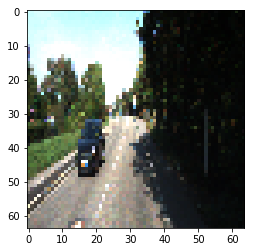

In [41]:
plt.imshow(image)

In [42]:
res = np.argmax(out, axis=-1).astype(np.uint8)

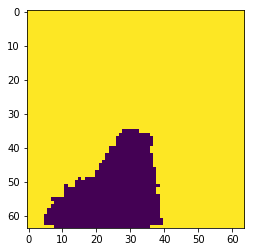

In [43]:
plt.imshow(res)

In [82]:
np.max(res)

0

In [ ]:
# contineu training a bit
tensorboardCB = TensorBoard(log_dir=os.path.join('tensorboard_graphs', 'fcn-keras/run2'), write_graph=True)
checkpointCB = ModelCheckpoint('checkpoints/fcn.-run2-epoch{epoch:02d}.h5', monitor=pixelwise_crossentropy, save_weights_only=False, mode='max', period=3)
callbacks = [tensorboardCB, checkpointCB]